First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [57]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
import os
from nltk.corpus import PlaintextCorpusReader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.ensemble import RandomForestClassifier                          
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC   
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

The goal of this project is to train a model with texts from different authors, and determine the accuracy of the model when predicting from which author a new text belongs.


Selecting 10 authors with literary works


In [59]:
pwd

'C:\\Users\\18644\\Desktop\\THINKFUL\\Data Science Bootcamp\\UNIT 4\\Lesson 4'

In [156]:
# Make list of individual file ids
file_info = os.listdir('Unsupervised capstone books')

# Create blank labels list to populate
labels = []

# Iterate through list of files pulling out the author's name
for file in file_info:
    
    # label author for each text 
    author = re.sub("[^a-zA-Z]", '', file[0:4])
       
    # Append to labels list
    labels.append([file, author])

In [62]:
corpus_root = 'Unsupervised capstone books'
newcorpus = PlaintextCorpusReader(corpus_root, '.*')

# Create blank lists to populate with sentence level data
sent_list = []
auth_list = []

# Iterate through each book, create sentence level documents, maintaining author
# information for each sentence
for i in range(len(labels)):
    sents = newcorpus.sents(labels[i][0]) #get sentences from document
    joined_sents = [(' '.join(sent), labels[i][1]) for sent in sents]
    
    # write out to individual lists for easier text processing
    for i in range(len(joined_sents)): 
        sent_list.append(joined_sents[i][0]) 
        auth_list.append(joined_sents[i][1])  

print(len(sent_list))
sent_list[:5]

2698


['350 BC', 'CATEGORIES', 'by Aristotle', 'translated by E . M . Edghill', '1']

Clean the sentences

In [64]:
sent_list_clean = []

for sent in sent_list:
    sent = re.sub("[^a-zA-Z]", ' ', sent) #removing numeric and punctuation, all caps header sentence, replace with blank
    if sent == sent.upper():
         sent = ""
    sent_list_clean.append(sent)
        
        
#Inspect the cleaned sentences

print(len(sent_list_clean))   
sent_list_clean[:5]

2698


['', '', 'by Aristotle', 'translated by E   M   Edghill', '']

Now let us tokenize the sentences into words and get lemmas

In [66]:
# import these modules 
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

# Create list to hold lemmatized sentences
lemma_sents = []

# Tokenize, get lemmas, and rejoin back to sentence level doc
for sent in sent_list_clean:
    words = word_tokenize(sent)                                 
    word_lemma = [lemmatizer.lemmatize(word) for word in words] 
    sent_lemma = ' '.join(word_lemma)                           
    lemma_sents.append(sent_lemma)

# Inspect results
lemma_sents[:5]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\18644\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['', '', 'by Aristotle', 'translated by E M Edghill', '']

We will now create a dataframe with the cleaned lists and remove all the blank lines. We will then move on to some unsupervised feature generation.

In [67]:
#Create dataframe
df = pd.DataFrame()
df['sent']= lemma_sents
df['author']= auth_list
# Remove blank documents 
df = df[df.sent!=""]
df.head()

,sent,author
2,by Aristotle,aris
3,translated by E M Edghill,aris
5,Things are said to be named equivocally when t...,aris
6,Thus a real man and a figure in a picture can ...,aris
7,For should any one define in what sense each i...,aris


In [68]:
# Examinng class balance.
print((df.groupby('author').count()/df['sent'].count())*100)

             sent
author           
aris    21.861885
emer    14.650897
jeff     1.640595
kant    11.064479
keat     9.156810
plat     6.219000
poe      3.967951
shak    12.132774
stev    15.604731
wild     3.700878


In [78]:
#Splitting the dataframe to train and test sets
df_train, df_test =train_test_split(df, stratify = df['author'], test_size =0.3, random_state=42)

print(df_train.shape)
print(df_test.shape)

(1834, 2)
(787, 2)


TF-IDF Vector
The first feature generation technique we'll use is to create term frequency-inverse document frequency (TF-IDF) vectors for each word. The following components make up the TF-IDF value:

Document frequency - How many documents the word appears in. More common words will have a higher document frequency.
Inverse document frequency - Takes the log (base 2) of the ratio between the total documents to the document frequency. More frequeny words are penalized whereas less common words become more influential.
Term frequency - How many times the term appears in a document. In our case, it's how many times a word appears in a sentence.
Tf-idf - Product of the term frequency multiplied by the inverse document frequency. Largest tf-idf scores will represent words that occur a lot in a small number of sentences, and the lowest for a word that occurs in many sentences. The benefit of tf-idf is that you can identify unique words that may help distinguish text documents from one another.


In [90]:
#We can calculate our TF-IDF vector matrix using TfidfVectorizer. 
#The latter allows us to clean up more our sentences removing stop words and applying lowercase to everything.

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm='l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )



X_train = df_train['sent']
X_test = df_test['sent']

#Vectorizing the train and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)



(1834, 2598)
(787, 2598)


In [91]:
# Calculate weights on training data
weights = np.asarray(X_train_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'avg_weight': weights})
print("Train:\n", weights_df.sort_values(by='avg_weight', ascending=False).head(10))

#Calculate the weights on test data
weights = np.asarray(X_test_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word':vectorizer.get_feature_names(), 'avg_weight':weights})
print('Test"\n', weights_df.sort_values(by='avg_weight', ascending=False).head(10))

Train:
           word  avg_weight
2457        wa    0.018803
1372       man    0.016083
2291     thing    0.015601
465   contrary    0.011714
1268       law    0.010544
23      action    0.010381
1012        ha    0.010164
2315      time    0.009887
1912      said    0.009636
1768   quality    0.009576
Test"
           word  avg_weight
1372       man    0.016691
2457        wa    0.016543
313       case    0.016270
1311      like    0.014171
1268       law    0.012923
465   contrary    0.012436
2296      thou    0.012112
1012        ha    0.011863
2315      time    0.011700
537        day    0.011620


Latent Semantic Analysis using Singular Value Decomposition
Latent Semantic Analysis (also called Latent Semantic Indexing) is the process of applying PCA to a tf-idf term-document matrix. What we get, in the end, is clusters of terms that presumably reflect a topic. Each document will get a score for each topic, with higher scores indicating that the document is relevant to the topic. Documents can pertain to more than one topic.

In [92]:
# Reduce feature space to ~30% of original
svd = TruncatedSVD(600)

# Make pipeline to run svd and normalize results
lsa_pipe = make_pipeline(svd, Normalizer())

# Fit with training data, transform test data
X_train_lsa = lsa_pipe.fit_transform(X_train_tfidf)
X_test_lsa = lsa_pipe.transform(X_test_tfidf)

# Examine variance captured in reduced feature space
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_lsa, index=X_train)

# Look at values from first 5 components
for i in range(6):
    print('Component {}:'.format(i))
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5])

Percent variance captured by components: 76.15350150887224
Component 0:
sent
Again if great and small are contrary it will come about that the same subject can admit contrary quality at one and the same time and that thing will themselves be contrary to themselves                                                                                                                                                                                                                                          0.424574
For man is predicated of the individual man but is not present in any subject for manhood is not present in the individual man                                                                                                                                                                                                                                                                                                       0.407424
Man is thus metamorphosed into a thing into many thing         

We have reduced the feature space by 30% and captured 76% variance

Supervised models
We will try out our feature sets on different classification models and see how well they perform
Random Forest Classifier
Logistic Regression
Gradient Boost Classifier

In [102]:
# Target variables
Y_train = df_train['author']
Y_test = df_test['author']

In [104]:
#TFIDF Features
X_train=X_train_tfidf
X_test = X_test_tfidf

In [147]:
# Specify the classifier
rf_params = {
    'n_estimators':100,
    'max_depth':3,
    'random_state':42,
    'class_weight':'balanced' 
}  
rfm = RandomForestClassifier(** rf_params)
rfm.fit(X_train, Y_train)
rfm_predictions = rfm.predict(X_test)

print('Train accuracy:', rfm.score(X_train, Y_train))
print('Test accuracy:', rfm.score(X_test, Y_test))

Train accuracy: 0.6526717557251909
Test accuracy: 0.5781448538754765


Accuracy Score for Random Forest Model: 0.5781448538754765


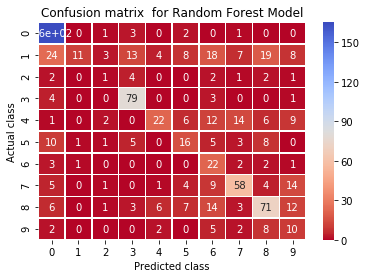

In [148]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
print("Accuracy Score for Random Forest Model: {}".format(accuracy_score(Y_test, rfm_predictions)))
Confusion_matrix = confusion_matrix(Y_test, rfm_predictions)
sns.heatmap(Confusion_matrix,
           cmap= 'coolwarm_r',
           annot = True,
           Linewidths = 0.5
)
plt.title('Confusion matrix  for Random Forest Model')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

Train accuracy: 0.6526717557251909
Test accuracy: 0.5781448538754765
Accuracy Score for Random Forest Model: 0.5781448538754765


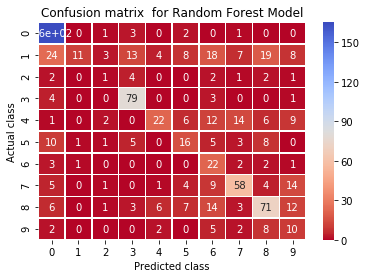

In [134]:
#LSA Features
X_train = X_train_lsa
X_test= X_test_lsa
# Specify the classifier
rf_params = {
    'n_estimators':100,
    'max_depth':3,
    'random_state':42,
    'class_weight':'balanced' 
}  
rfm = RandomForestClassifier(** rf_params)
rfm.fit(X_train, Y_train)
rfm_predictions = rfm.predict(X_test)

print('Train accuracy:', rfm.score(X_train, Y_train))
print('Test accuracy:', rfm.score(X_test, Y_test))
print("Accuracy Score for Random Forest Model: {}".format(accuracy_score(Y_test, rfm_predictions)))
Confusion_matrix = confusion_matrix(Y_test, rfm_predictions)
sns.heatmap(Confusion_matrix,
           cmap= 'coolwarm_r',
           annot = True,
           Linewidths = 0.5
)
plt.title('Confusion matrix  for Random Forest Model')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

We can see both tfidf and LSM features set performed similar with train and test sets. We can see that in both sets, we predominantely identified the first authors sentences

In [136]:
# Use model to get feature importance
feat_importance = rfm.fit(X_train_tfidf, Y_train).feature_importances_
features = vectorizer.get_feature_names()

importance_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'importance': feat_importance})
importance_df.sort_values(by='importance', ascending=False).head(10)

,word,importance
2457,wa,0.053197
1716,principle,0.035644
1205,island,0.026241
1268,law,0.023300
1299,let,0.023017
680,duty,0.022661
2030,sing,0.022063
973,government,0.017460
32,administration,0.014755
384,clock,0.014194


We can see 'wa' as the most important word followed by 'principle'

In [ ]:
Logistic Regression

C:\Users\18644\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\18644\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train accuracy: 0.8985823336968375
Test accuracy: 0.7280813214739518
Accuracy Score for Random Forest Model: 0.7280813214739518


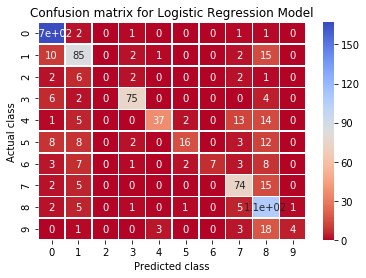

In [158]:
#tfidf features
X_train=X_train_tfidf
X_test = X_test_tfidf

#Fitting the model
lr= LogisticRegression()
lr.fit(X_train, Y_train)
lr_pred= lr.predict(X_test)

print('Train accuracy:', lr.score(X_train, Y_train))
print('Test accuracy:', lr.score(X_test, Y_test))
print("Accuracy Score for Random Forest Model: {}".format(accuracy_score(Y_test, lr_pred)))
Confusion_matrix = confusion_matrix(Y_test, lr_pred)
sns.heatmap(Confusion_matrix,
           cmap= 'coolwarm_r',
           annot = True,
           Linewidths = 0.5
)
plt.title('Confusion matrix for Logistic Regression Model')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

C:\Users\18644\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train accuracy: 0.8838604143947656
Test accuracy: 0.7560355781448539
Accuracy Score for Logistic Regression Model: 0.7560355781448539


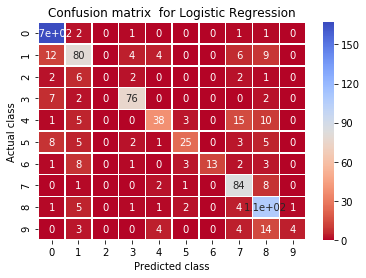

In [159]:
#LSA features 
X_train = X_train_lsa
X_test= X_test_lsa

lr= LogisticRegression()
lr.fit(X_train, Y_train)
lr_pred= lr.predict(X_test)

print('Train accuracy:', lr.score(X_train, Y_train))
print('Test accuracy:', lr.score(X_test, Y_test))
print("Accuracy Score for Logistic Regression Model: {}".format(accuracy_score(Y_test, lr_pred)))
Confusion_matrix = confusion_matrix(Y_test, lr_pred)
sns.heatmap(Confusion_matrix,
           cmap= 'coolwarm_r',
           annot = True,
           Linewidths = 0.5
)
plt.title('Confusion matrix  for Logistic Regression')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

The perfromace of the model increased slight with lsm features and the logistic regression seems to perform better than random forest in predicting correctly author 1, 8 , 7 and 3.

In [ ]:
Gradient Boosting model

Train accuracy: 0.9934569247546347
Test accuracy: 0.7026683608640406
Accuracy Score for Gradient Boosting Model: 0.7026683608640406


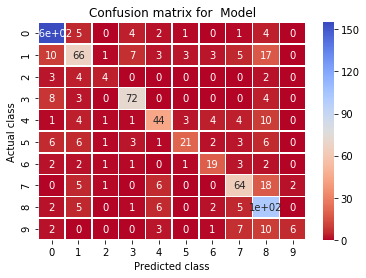

In [155]:
# Gradient Boosting Parameters
gb_params ={
    'n_estimators': 1500,
    'max_features': 0.9,
    'learning_rate' : 0.25,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'random_state' : 42,
    'verbose': 0
}
#TFIDF Features
X_train=X_train_tfidf
X_test = X_test_tfidf

#tfidf features
gb = GradientBoostingClassifier(**gb_params)
# Fit the model =
gb.fit(X_train, Y_train)
# Get our predictions
gb_pred= gb.predict(X_test)

print('Train accuracy:', gb.score(X_train, Y_train))
print('Test accuracy:', gb.score(X_test, Y_test))
print("Accuracy Score for Gradient Boosting Model: {}".format(accuracy_score(Y_test, gb_pred)))
Confusion_matrix = confusion_matrix(Y_test, gb_pred)
sns.heatmap(Confusion_matrix,
           cmap= 'coolwarm_r',
           annot = True,
           Linewidths = 0.5
)
plt.title('Confusion matrix for  Model')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

Train accuracy: 0.995092693565976
Test accuracy: 0.7293519695044473
Accuracy Score for Gradient Boosting Model: 0.7293519695044473


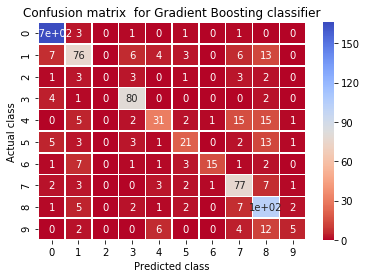

In [157]:
#LSA Features
X_train = X_train_lsa
X_test= X_test_lsa

gb = GradientBoostingClassifier(**gb_params)
# Fit the model 
gb.fit(X_train, Y_train)
# Get our predictions
gb_pred= gb.predict(X_test)

print('Train accuracy:',gb.score(X_train, Y_train))
print('Test accuracy:', gb.score(X_test, Y_test))
print("Accuracy Score for Gradient Boosting Model: {}".format(accuracy_score(Y_test, gb_pred)))
Confusion_matrix = confusion_matrix(Y_test, gb_pred)
sns.heatmap(Confusion_matrix,
           cmap= 'coolwarm_r',
           annot = True,
           Linewidths = 0.5
)
plt.title('Confusion matrix  for Gradient Boosting classifier')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

The gradient boosting classifier gives the accuracy of 99% on the set set (which indicate ovefitting of the model since the feature space is very high.)